# medMorphoBin - First project computer vision

- Sara Echeverría 21371
- Melissa Pérez 21385
- Ricardo Mendez 21289

repository link: https://github.com/bl33h/medMorphoBin

## Task 1

### implementing binarization algorithms

### Otsu

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
def readImage(path):
    return plt.imread(path)

In [3]:
def equalizeHist(image):
    hist, bins = np.histogram(image.flatten(), 256, [0,256])
    cdf = hist.cumsum()
    cdf = 255 * cdf / cdf[-1]
    equalized = np.interp(image.flatten(), bins[:-1], cdf)
    return equalized.reshape(image.shape).astype(np.uint8)

In [4]:
def evaluateMetrics(gt, pred):
    gtFlat, predFlat = gt.flatten(), pred.flatten()
    tp = np.sum((gtFlat == 1) & (predFlat == 1))
    tn = np.sum((gtFlat == 0) & (predFlat == 0))
    fp = np.sum((gtFlat == 0) & (predFlat == 1))
    fn = np.sum((gtFlat == 1) & (predFlat == 0))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, specificity, f1

In [5]:
def applyOtsuThreshold(image):
    hist, binEdges = np.histogram(image.ravel(), bins=256, range=(0,256))
    hist = hist.astype(float)
    totalPixels = image.size

    currentMax, threshold = 0, 0
    sumTotal, sumB, wB, wF = np.dot(hist, np.arange(256)), 0, 0, 0

    for i in range(256):
        wB += hist[i]
        if wB == 0: continue
        wF = totalPixels - wB
        if wF == 0: break

        sumB += i * hist[i]
        meanB = sumB / wB
        meanF = (sumTotal - sumB) / wF

        varianceBetween = wB * wF * (meanB - meanF) ** 2

        if varianceBetween > currentMax:
            currentMax = varianceBetween
            threshold = i

    # Generar imagen binaria con valores 0 y 255
    binaryImage = np.where(image > threshold, 255, 0).astype(np.uint8)
    return binaryImage

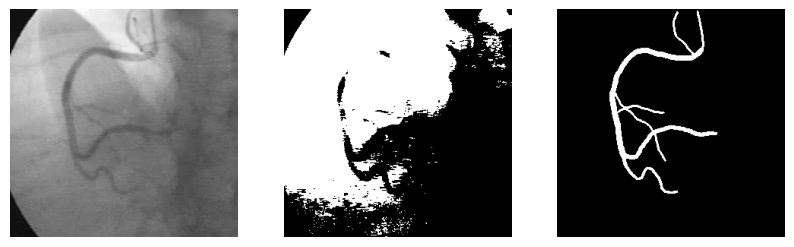

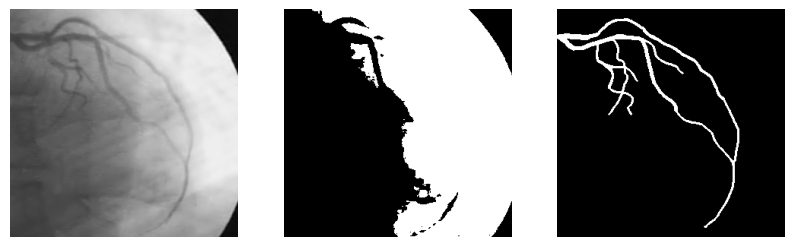

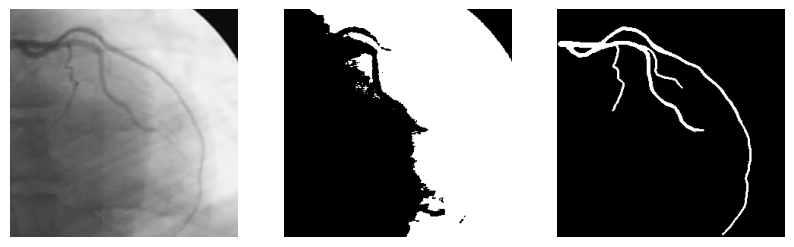

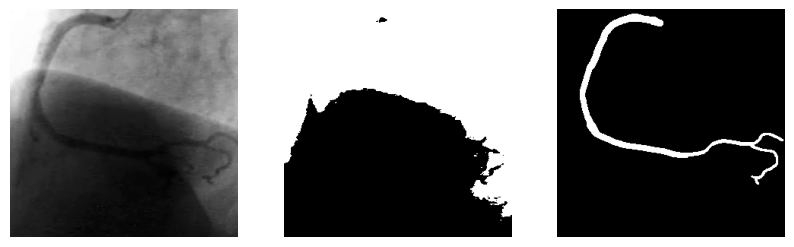

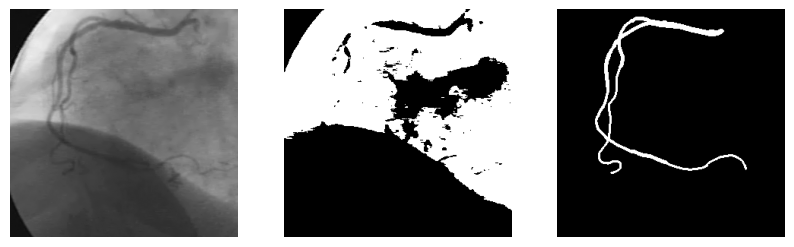

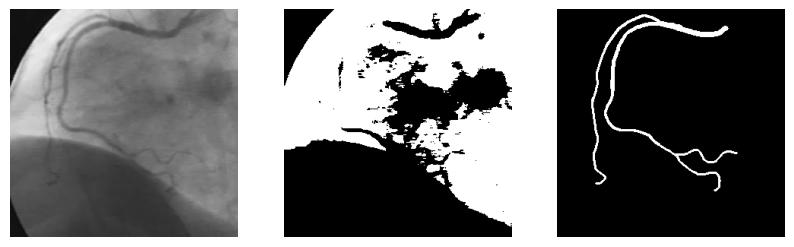

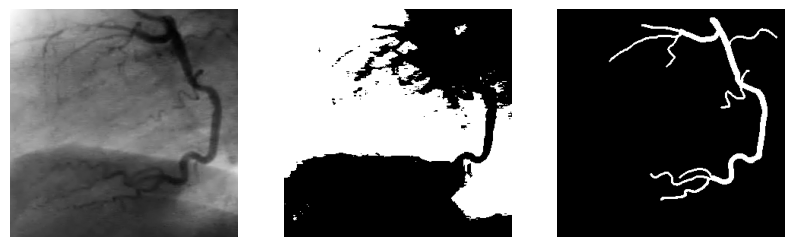

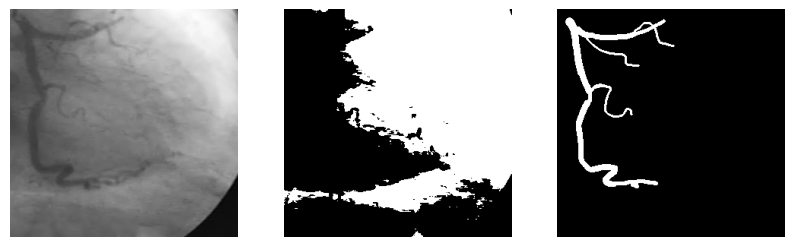

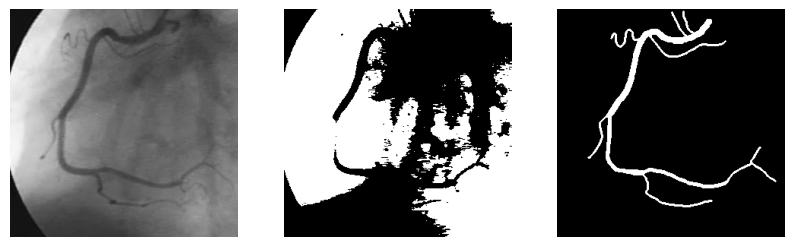

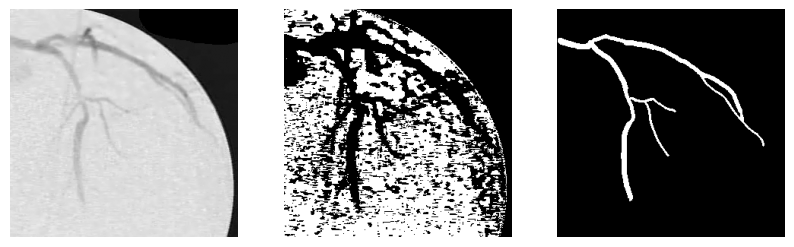

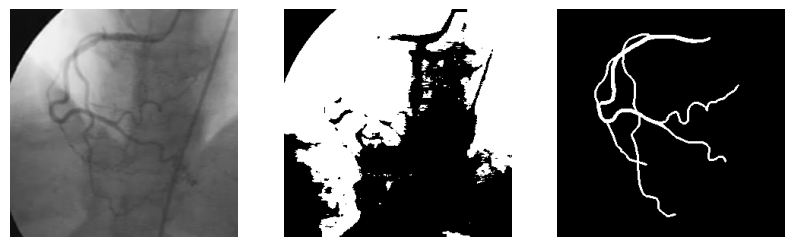

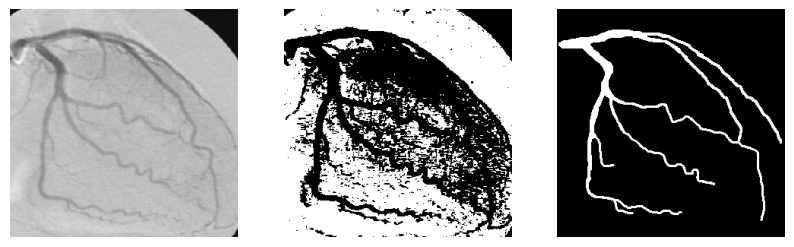

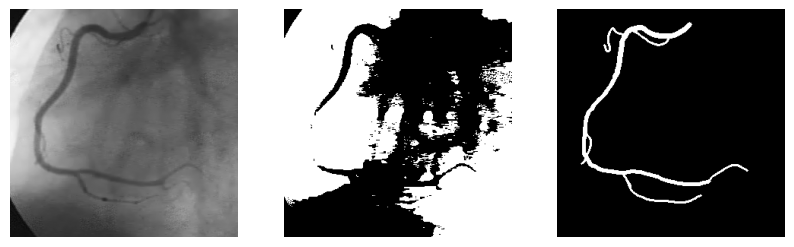

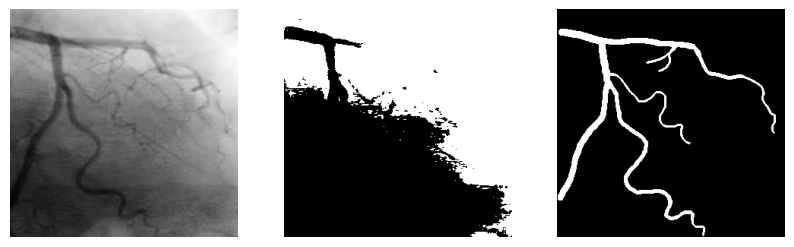

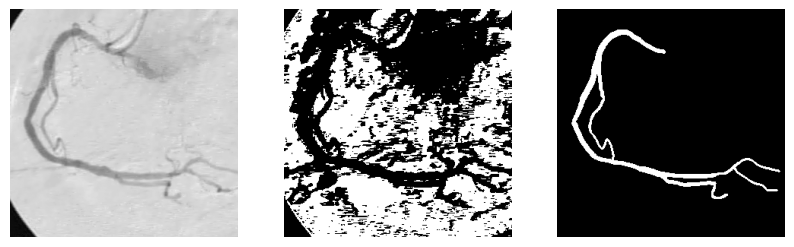

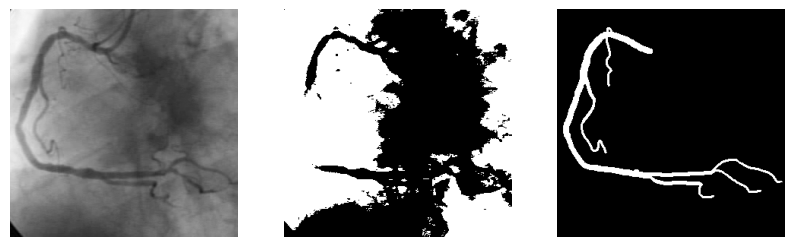

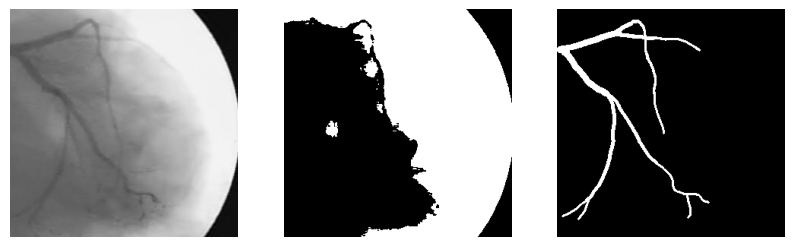

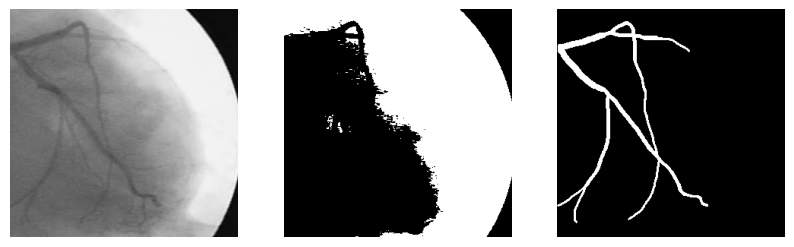

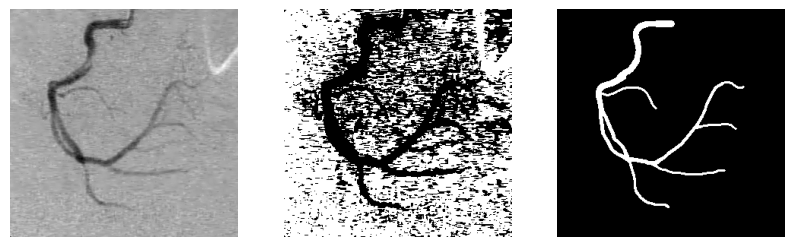

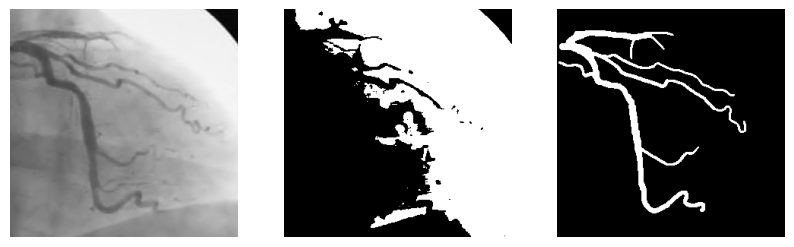

--- metrics otsu ---
accuracy: 0.9192648531654155
precision: 0.0
recall: 0.0
specificity: 1.0
f1 score: 0.0


In [6]:
# main execution
path = "img/"
metricsSum = np.zeros(5)

for imgNum in range(1, 21):
    image = readImage(f"{path}{imgNum}.pgm")
    gtImage = readImage(f"{path}{imgNum}_gt.pgm")
    
    imageEq = equalizeHist(image)
    binaryImg = applyOtsuThreshold(imageEq)
    
    metrics = evaluateMetrics((gtImage==255).astype(np.uint8), binaryImg)
    metricsSum += metrics

    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(binaryImg, cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(gtImage, cmap='gray')
    plt.axis('off')

    plt.show()

metricsAvg = metricsSum / 20

print('--- metrics otsu ---')
print('accuracy:', metricsAvg[0])
print('precision:', metricsAvg[1])
print('recall:', metricsAvg[2])
print('specificity:', metricsAvg[3])
print('f1 score:', metricsAvg[4])

### Sauvola

In [7]:
def sauvolaThreshold(image, windowSize=23, k=0.4):
    rows, cols = image.shape
    padSize = windowSize // 2
    padded = np.pad(image, padSize, mode='reflect')
    thresholded = np.zeros_like(image)

    for i in range(rows):
        for j in range(cols):
            window = padded[i:i+windowSize, j:j+windowSize]
            meanLocal = np.mean(window)
            stdLocal = np.std(window)
            threshold = meanLocal * (1 + k * ((stdLocal / 128) - 1))
            thresholded[i, j] = threshold

    return thresholded

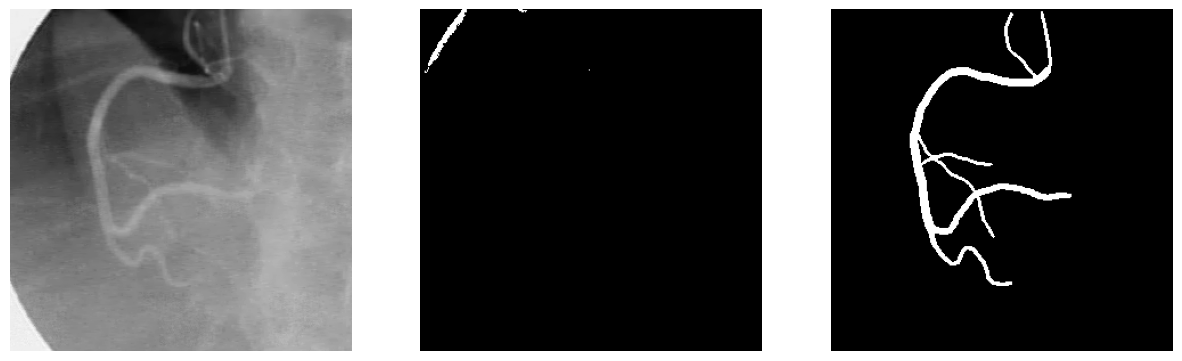

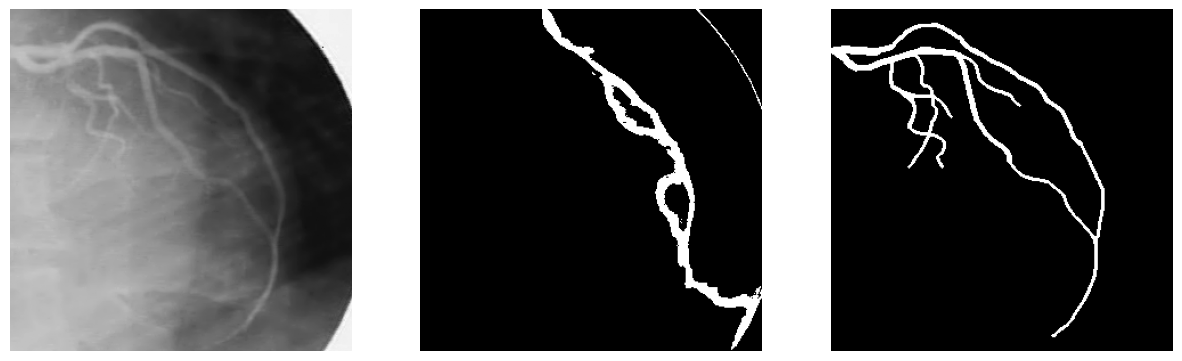

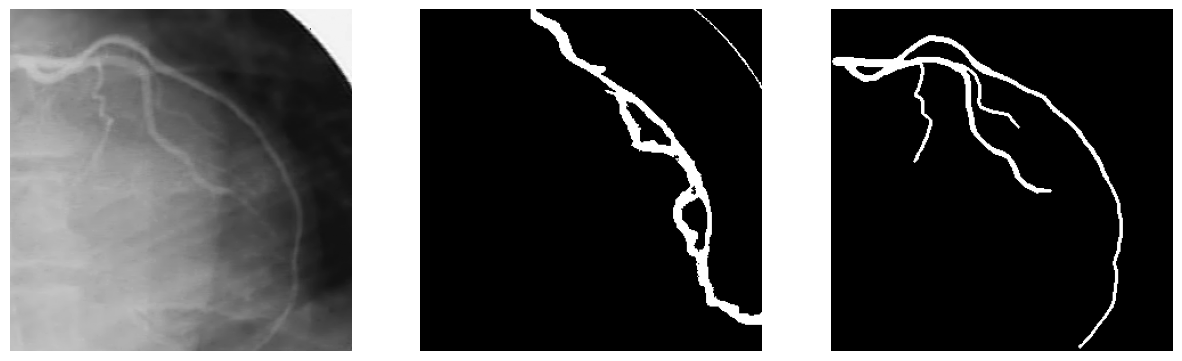

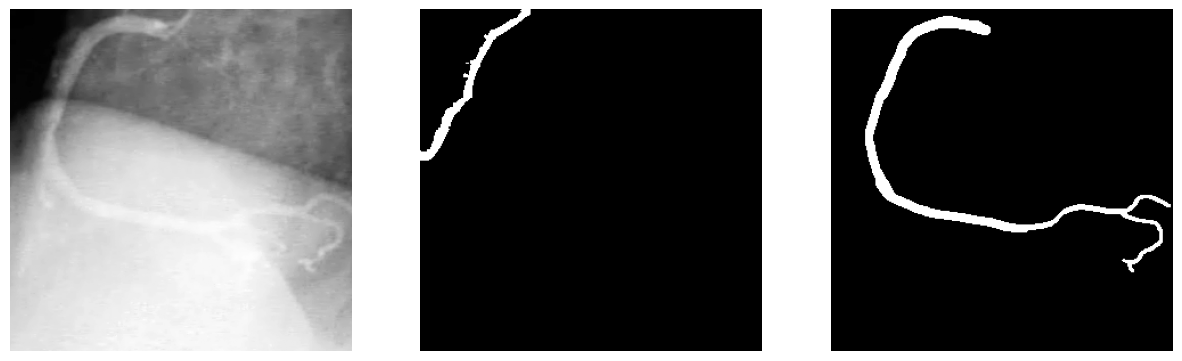

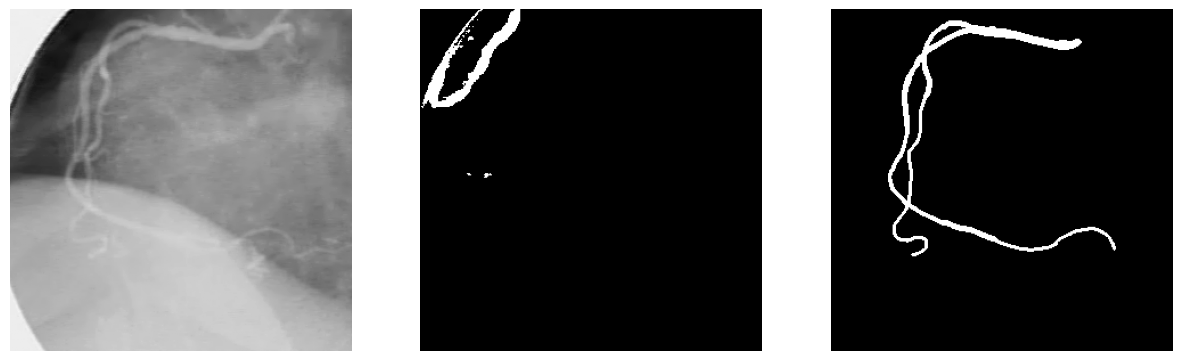

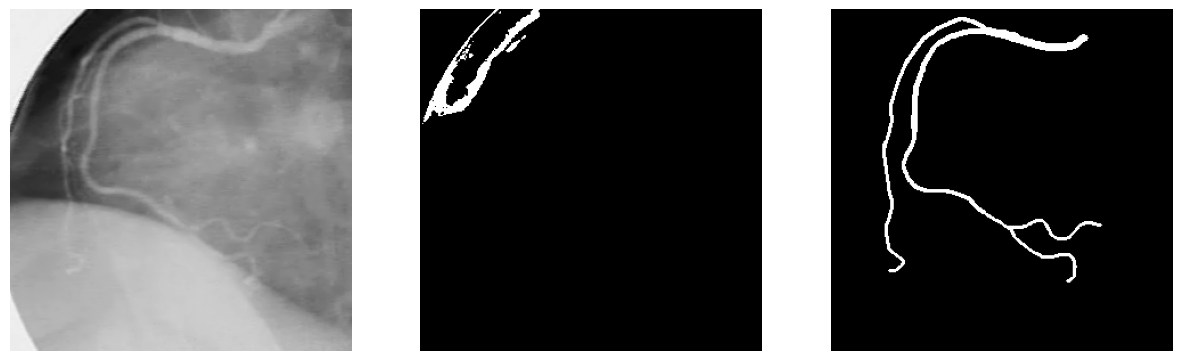

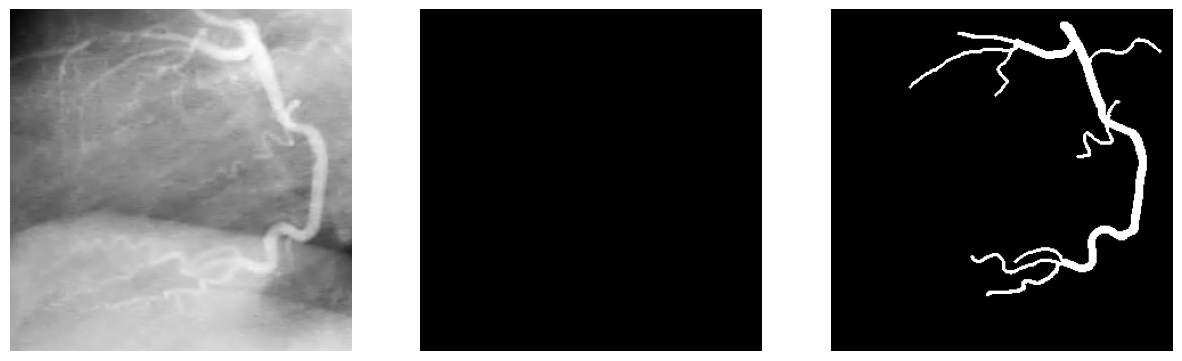

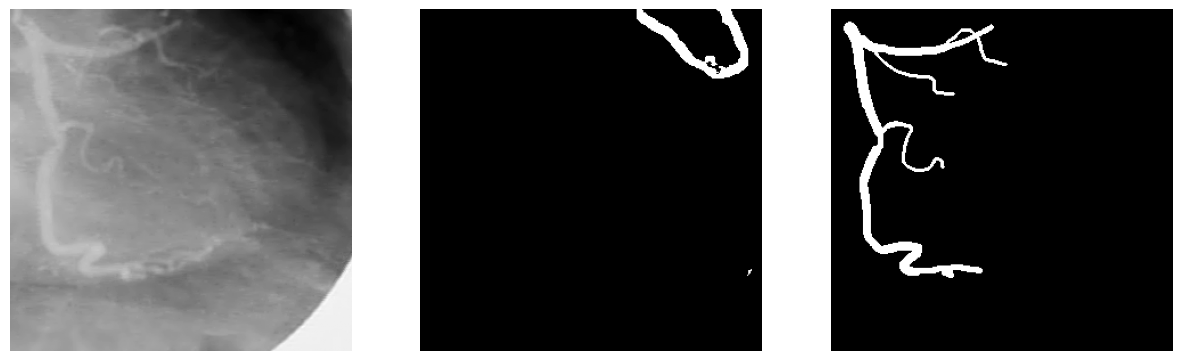

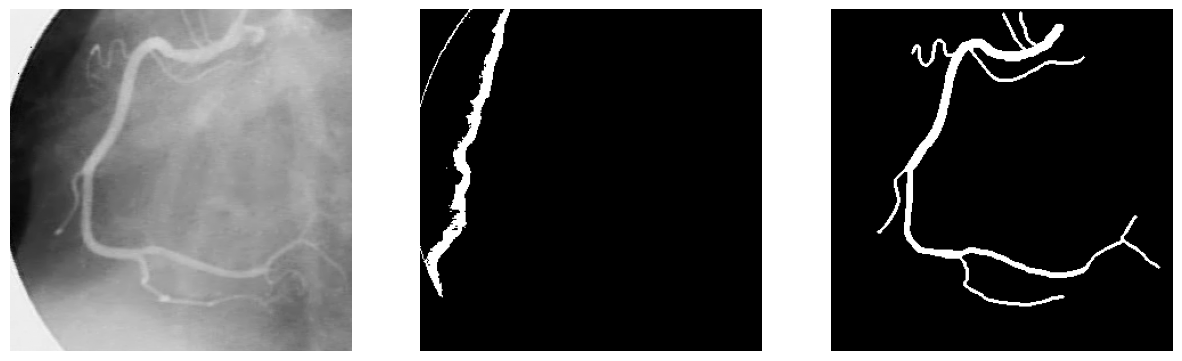

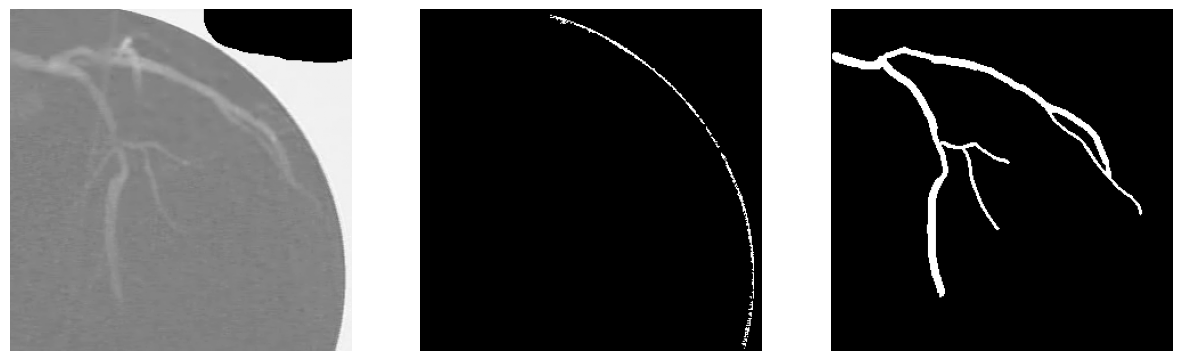

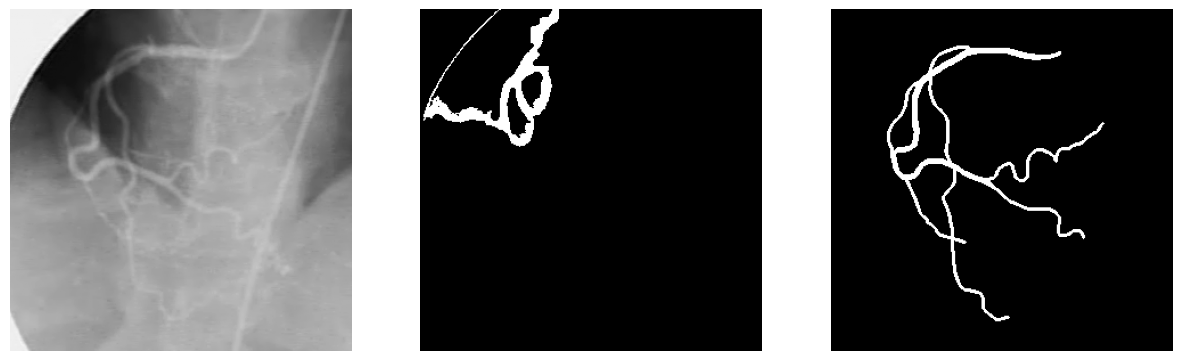

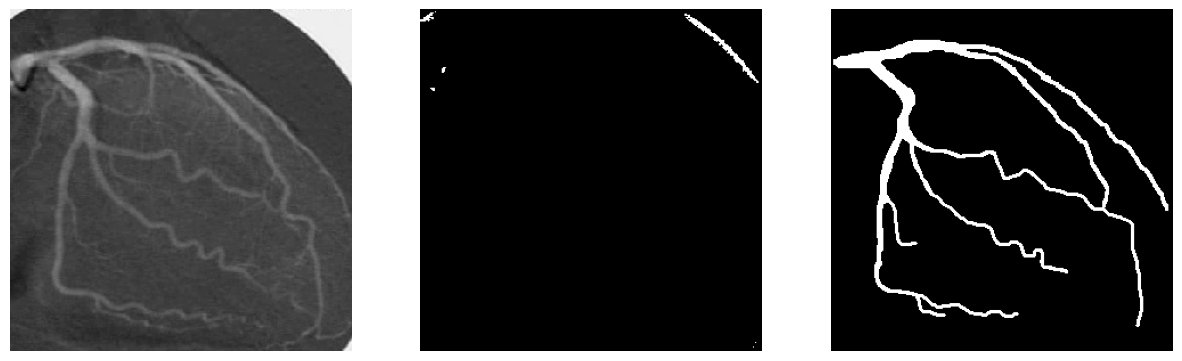

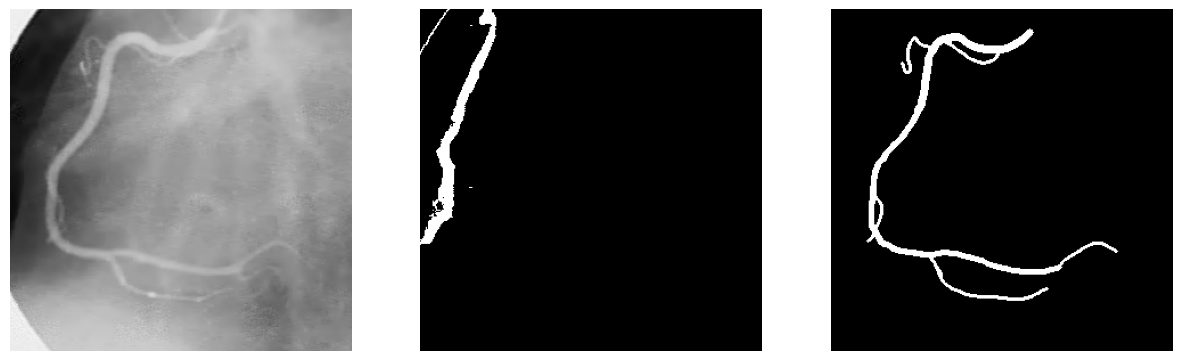

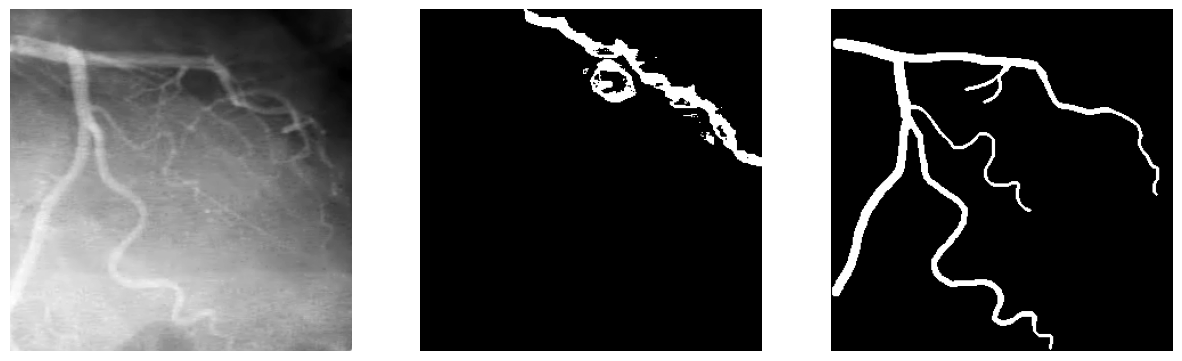

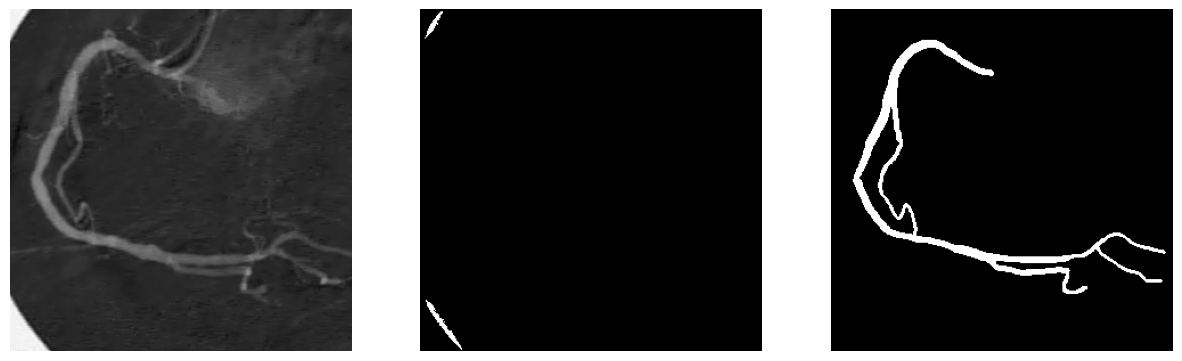

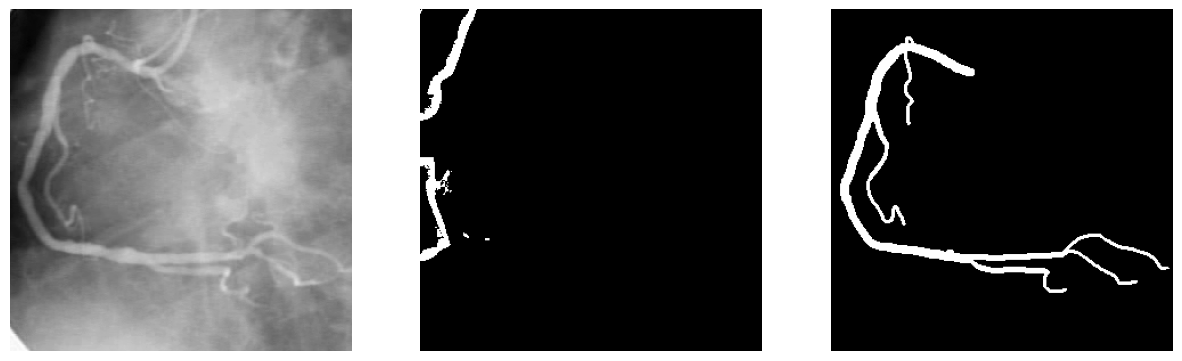

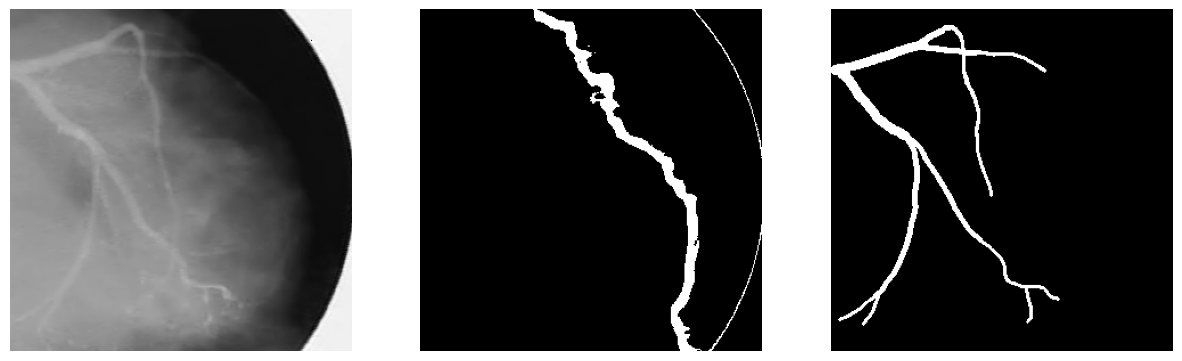

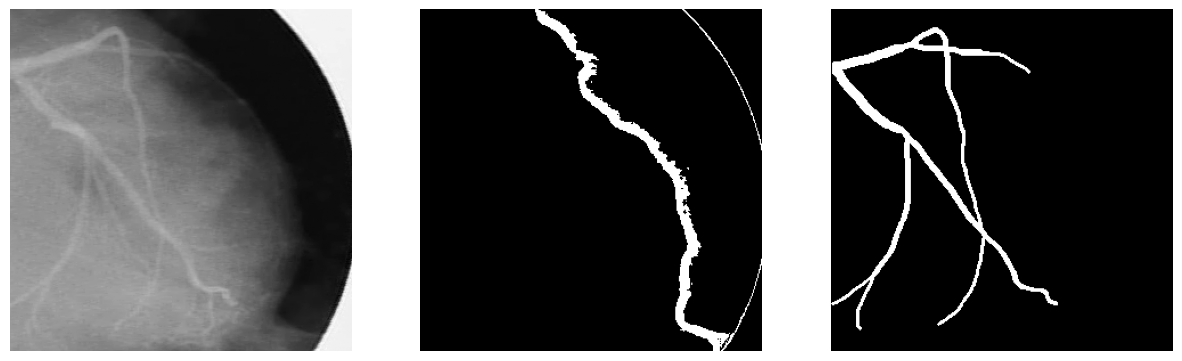

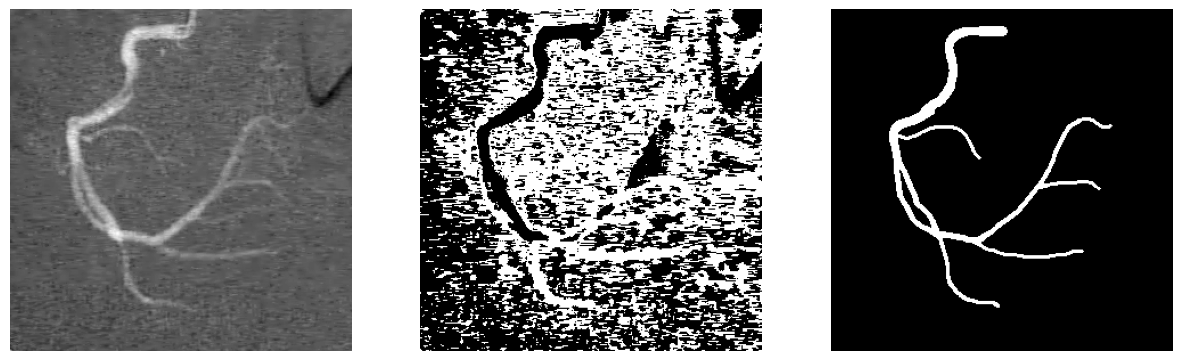

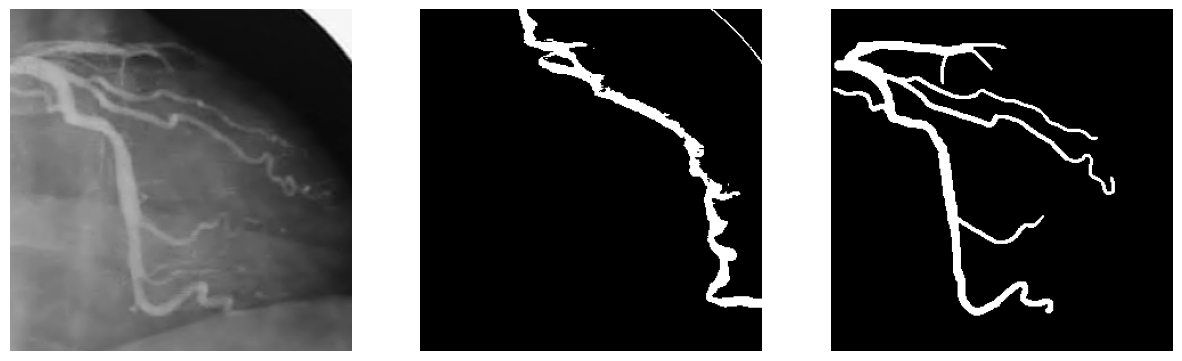

In [8]:
minIntensity = 55
sauvolaMetricsSum = np.zeros(5)

for i in range(1, 21):
    ruta = f"{path}{i}.pgm"
    rutaAnalizada = f"{path}{i}_gt.pgm"

    originalImageGray = readImage(ruta) * 255
    gtImage = readImage(rutaAnalizada) * 255

    mask = originalImageGray > minIntensity
    imageForSauvola = originalImageGray.copy()
    imageForSauvola[~mask] = 255

    sauvolaThresh = sauvolaThreshold(imageForSauvola)
    sauvolaBinary = (imageForSauvola > sauvolaThresh).astype(np.uint8)
    sauvolaBinary = 1 - sauvolaBinary

    gtNormalized = (gtImage == 255).astype(np.uint8)
    sauvolaMetrics = evaluateMetrics(gtNormalized, sauvolaBinary)
    sauvolaMetricsSum += sauvolaMetrics

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(originalImageGray, cmap='gray')
    ax[0].axis('off')

    ax[1].imshow(sauvolaBinary, cmap='gray')
    ax[1].axis('off')

    ax[2].imshow(gtImage, cmap='gray')
    ax[2].axis('off')

    plt.show()

In [9]:
metricsAvg = sauvolaMetricsSum / 20

print('\n--- metrics sauvola ---')
print('accuracy:', metricsAvg[0])
print('f1:', metricsAvg[4])
print('recall/sensitivity:', metricsAvg[2])
print('specificity:', metricsAvg[3])
print('precision:', metricsAvg[1])



--- metrics sauvola ---
accuracy: 0.9534605555555556
f1: 0.0
recall/sensitivity: 0.0
specificity: 0.9534605555555556
precision: 0.0


### Adaptive

In [10]:
def adaptiveThreshold(image, windowSize=11, C=2):
    rows, cols = image.shape
    padSize = windowSize // 2
    padded = np.pad(image, padSize, mode='reflect')
    binaryImage = np.zeros_like(image)

    for i in range(rows):
        for j in range(cols):
            window = padded[i:i+windowSize, j:j+windowSize]
            localMean = np.mean(window)
            threshold = localMean - C
            binaryImage[i, j] = 0 if image[i, j] > threshold else 1

    return binaryImage.astype(np.uint8)

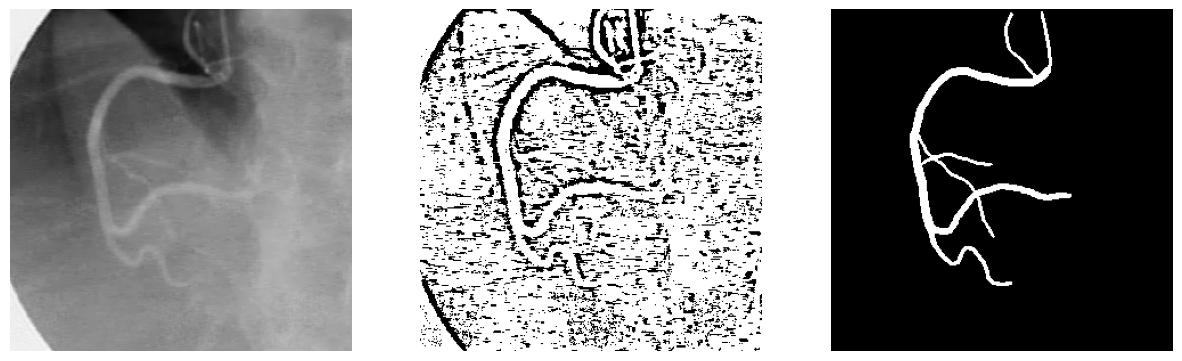

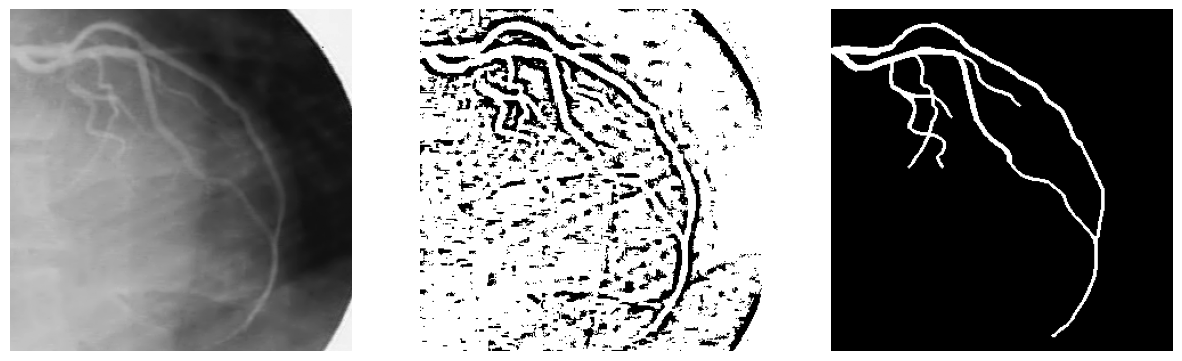

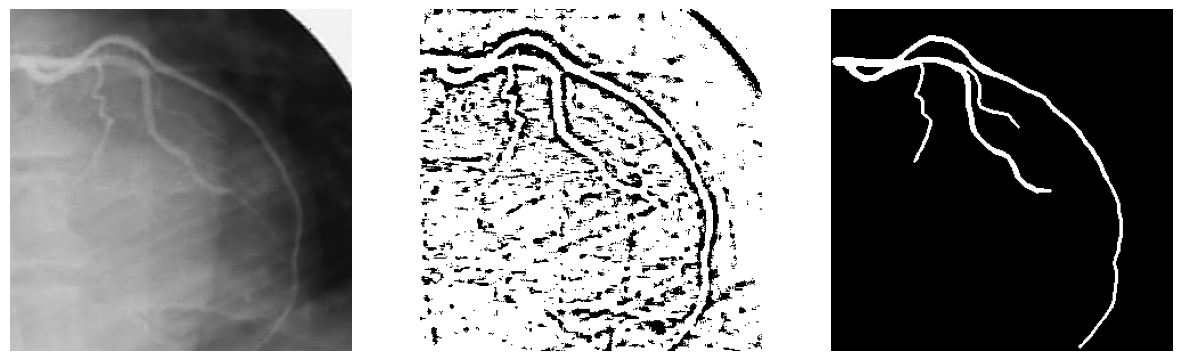

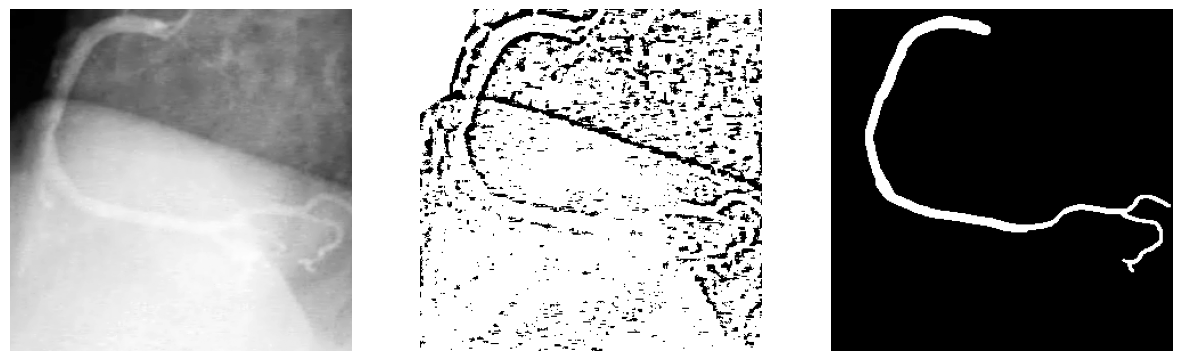

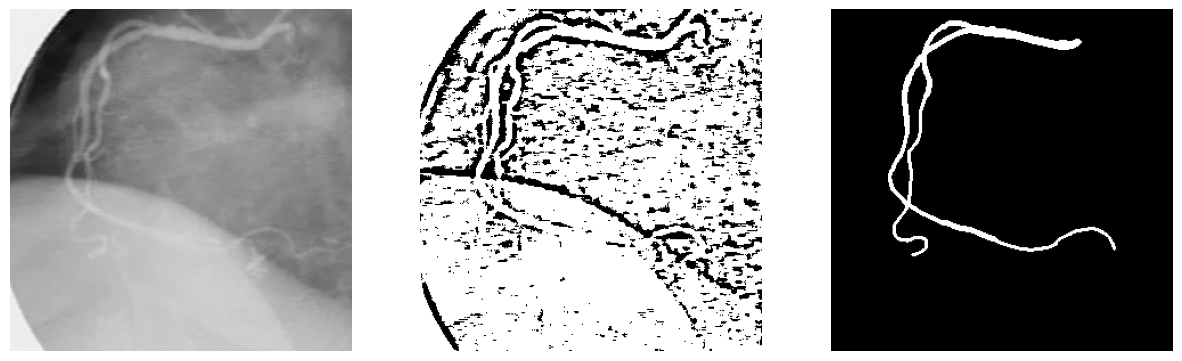

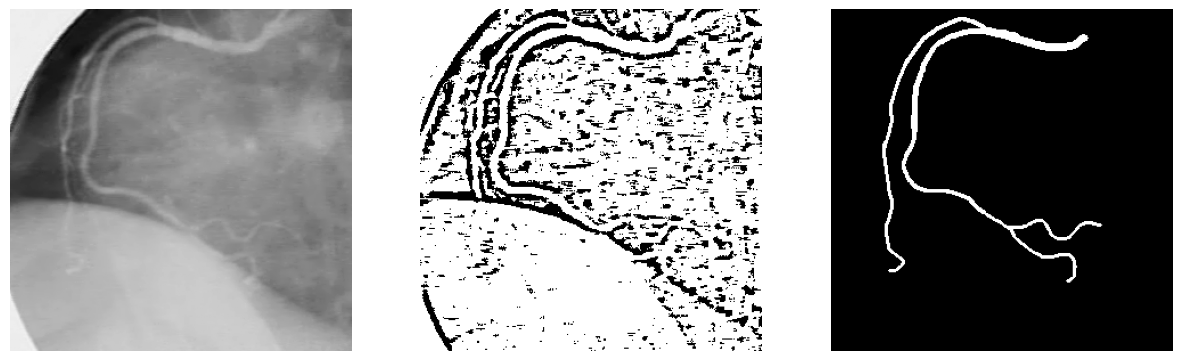

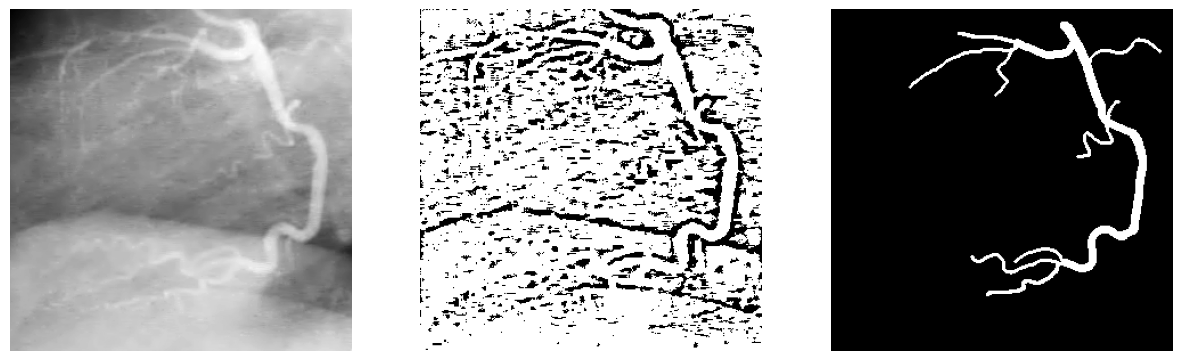

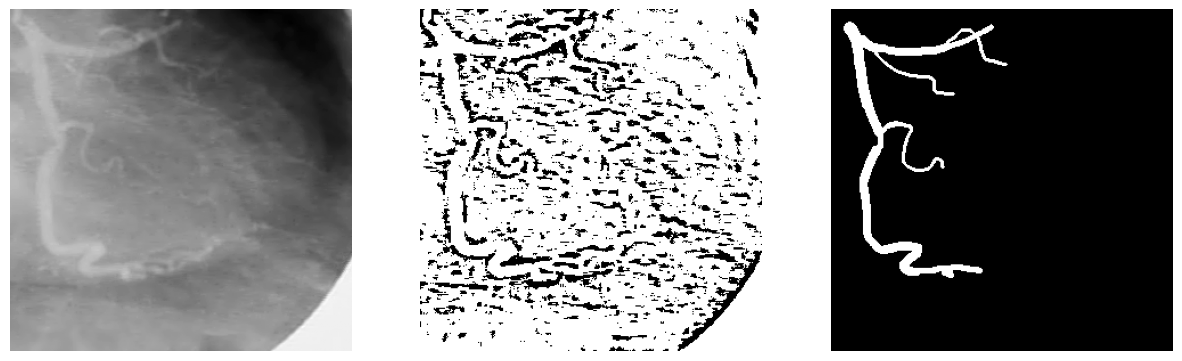

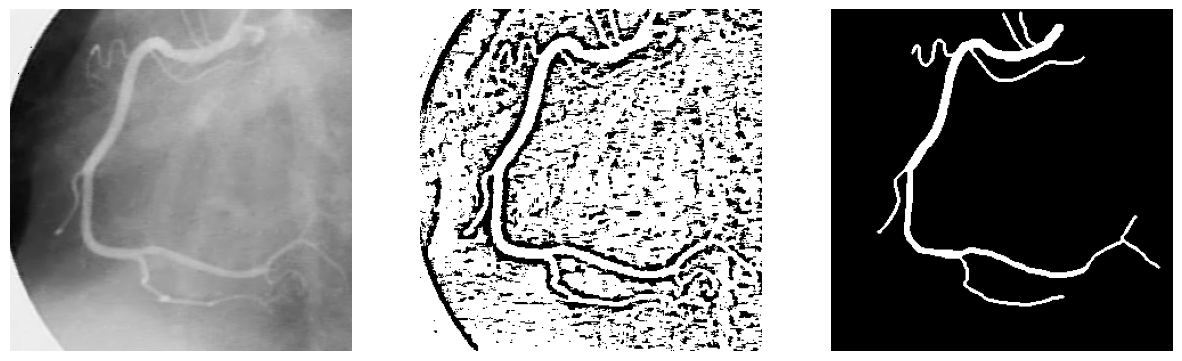

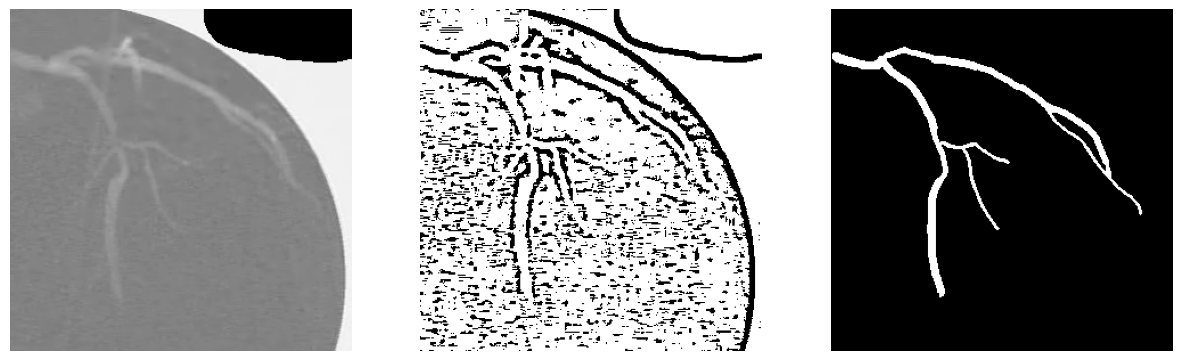

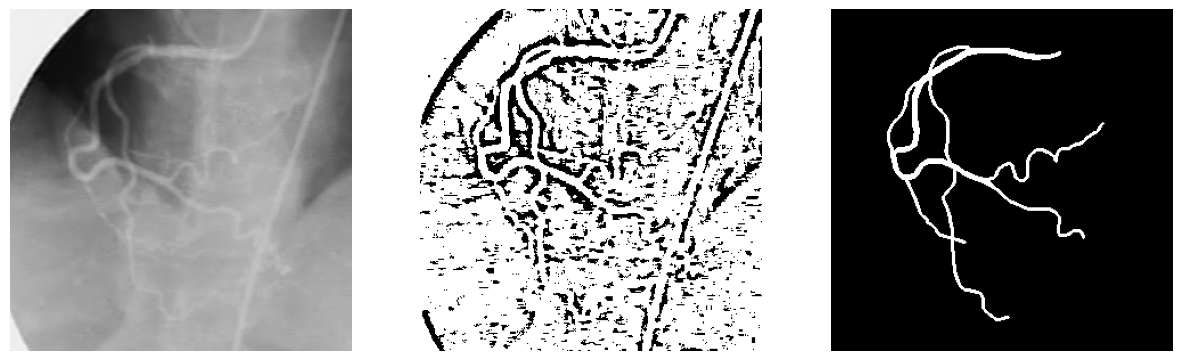

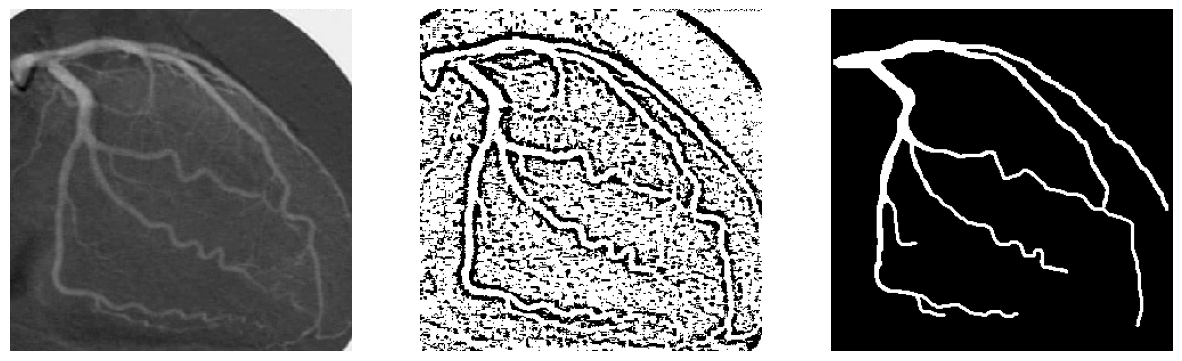

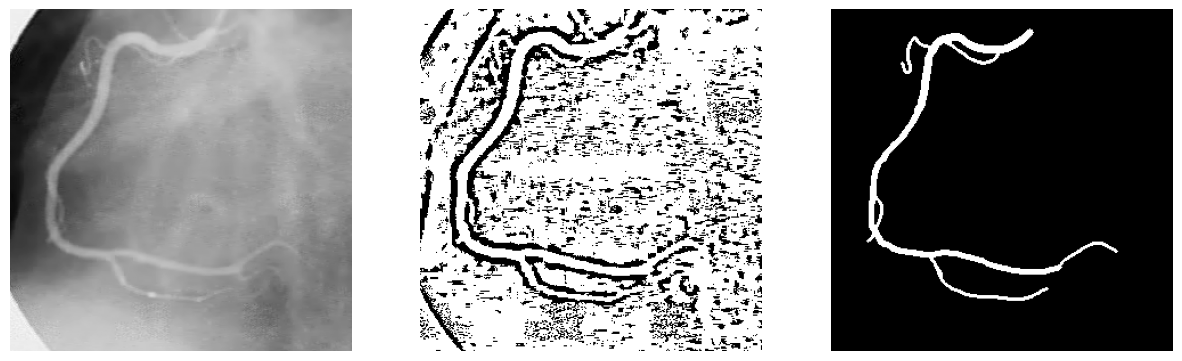

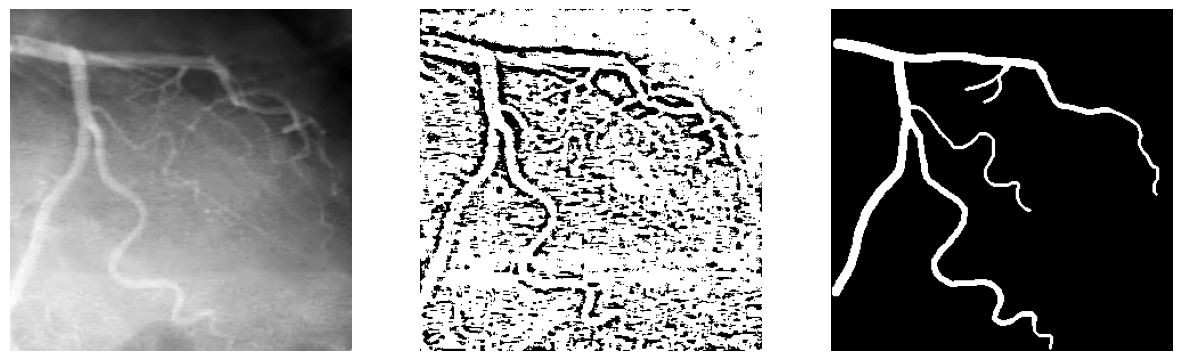

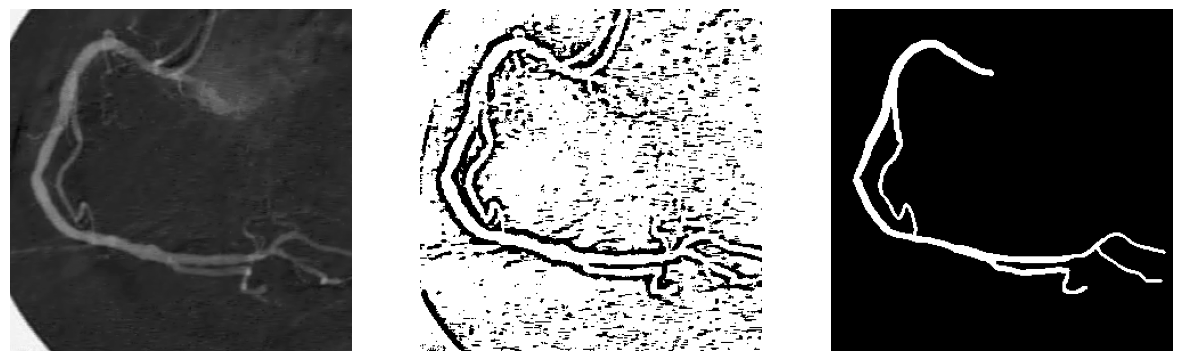

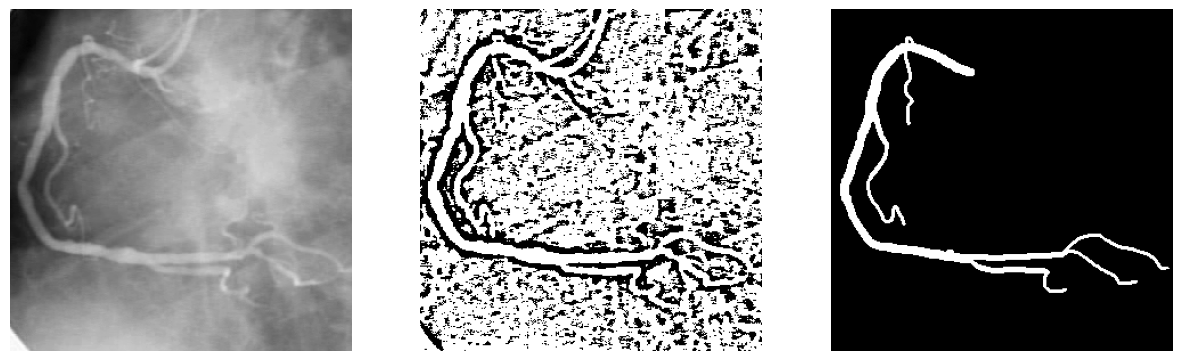

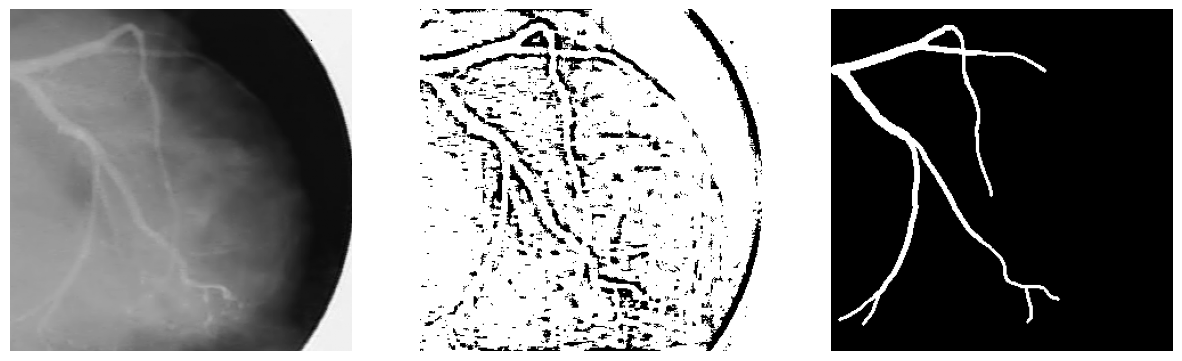

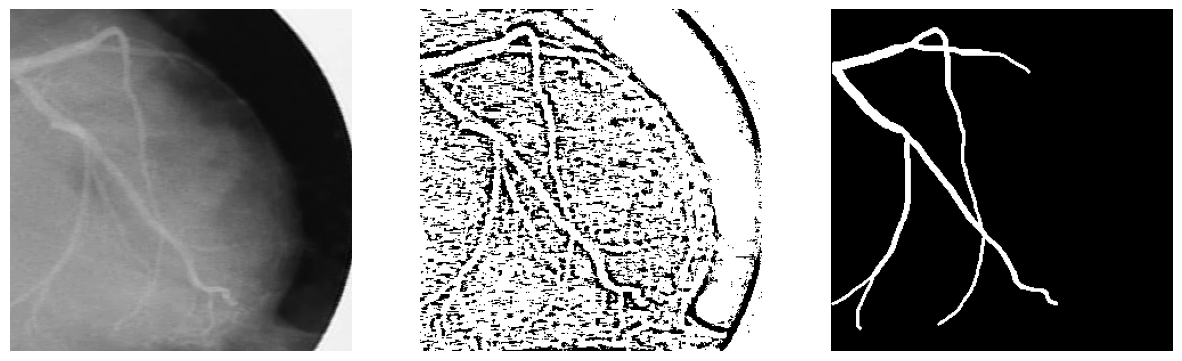

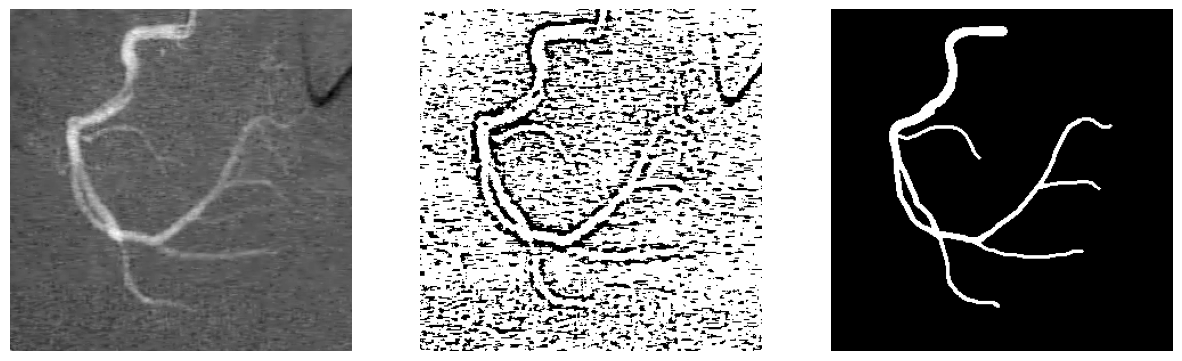

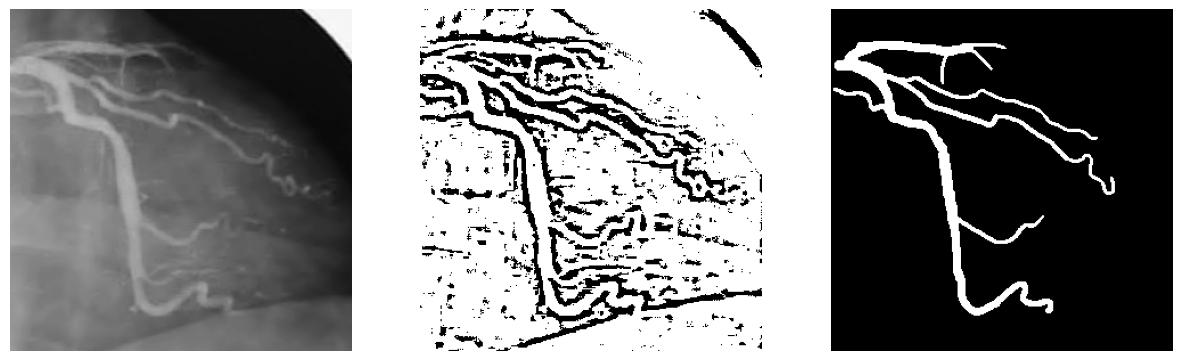

In [11]:
adaptiveMetricsSum = np.zeros(5)

for i in range(1, 21):
    ruta = f"{path}{i}.pgm"
    rutaAnalizada = f"{path}{i}_gt.pgm"

    originalImage = readImage(ruta) * 255
    gtImage = readImage(rutaAnalizada) * 255
    gtNormalized = (gtImage == 255).astype(np.uint8)

    adaptiveBinary = adaptiveThreshold(originalImage)
    adaptiveBinary = 1 - adaptiveBinary

    adaptiveMetrics = evaluateMetrics(gtNormalized, adaptiveBinary)
    adaptiveMetricsSum += adaptiveMetrics

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(originalImage, cmap='gray')
    ax[0].axis('off')

    ax[1].imshow(adaptiveBinary, cmap='gray')
    ax[1].axis('off')

    ax[2].imshow(gtImage, cmap='gray')
    ax[2].axis('off')

    plt.show()

metricsAvg = adaptiveMetricsSum / 20

In [12]:
print('\n--- metrics adaptive ---')
print('accuracy:', metricsAvg[0])
print('f1:', metricsAvg[4])
print('recall/sensitivity:', metricsAvg[2])
print('specificity:', metricsAvg[3])
print('precision:', metricsAvg[1])


--- metrics adaptive ---
accuracy: 0.20788777777777775
f1: 0.0
recall/sensitivity: 0.0
specificity: 0.20788777777777775
precision: 0.0


### Metrics evaluation

In [14]:
# metricas
def generate_metrics_table(metrics, algorithm_name):
    df = pd.DataFrame(metrics, columns=["Accuracy", "Recall", "Specificity", "Precision", "F1 Score"],
                      index=[f"Image {i+1}" for i in range(len(metrics))])
    print(f"\n--- Metrics for {algorithm_name} ---")
    print(df)
    print("\nAverage Metrics:")
    print(df.mean())

In [15]:
def evaluateMetrics(gt, pred):
    accuracy = accuracy_score(gt.flatten(), pred.flatten())
    precision = precision_score(gt.flatten(), pred.flatten(), zero_division=0)
    recall = recall_score(gt.flatten(), pred.flatten(), zero_division=0)
    f1 = f1_score(gt.flatten(), pred.flatten(), zero_division=0)
    
    tn, fp, fn, tp = confusion_matrix(gt.flatten(), pred.flatten()).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    return [accuracy, precision, recall, specificity, f1]

In [16]:
path = "img/"
otsu_metrics = []
sauvola_metrics = []
adaptive_metrics = []

for i in range(1, 21):
    ruta = f"{path}{i}.pgm"
    ruta_gt = f"{path}{i}_gt.pgm"

    originalImage = readImage(ruta)
    gtImage = readImage(ruta_gt)
    gtNormalized = (gtImage == 255).astype(np.uint8)

    # Otsu
    imageEq = equalizeHist(originalImage)
    binaryImg = applyOtsuThreshold(imageEq)
    binaryImg = (binaryImg > 0).astype(np.uint8) # <- Binarización de 0 y 1
    otsu_metrics.append(evaluateMetrics(gtNormalized, binaryImg))

    # Sauvola
    minIntensity = 55
    mask = originalImage > minIntensity
    imageForSauvola = originalImage.copy()
    imageForSauvola[~mask] = 255
    sauvolaThresh = sauvolaThreshold(imageForSauvola)
    sauvolaBinary = (imageForSauvola > sauvolaThresh).astype(np.uint8)
    sauvolaBinary = 1 - sauvolaBinary
    sauvola_metrics.append(evaluateMetrics(gtNormalized, sauvolaBinary))

    # Adaptive Threshold
    adaptiveBinary = adaptiveThreshold(originalImage)
    adaptiveBinary = 1 - adaptiveBinary
    adaptive_metrics.append(evaluateMetrics(gtNormalized, adaptiveBinary))


In [17]:
# Generar las tablas
generate_metrics_table(otsu_metrics, "Otsu")
generate_metrics_table(sauvola_metrics, "Sauvola")
generate_metrics_table(adaptive_metrics, "Adaptive Threshold")


--- Metrics for Otsu ---
          Accuracy    Recall  Specificity  Precision  F1 Score
Image 1   0.496589  0.040031     0.477916   0.497408  0.073874
Image 2   0.486033  0.031766     0.335452   0.493493  0.058037
Image 3   0.492622  0.030523     0.361657   0.498342  0.056295
Image 4   0.505744  0.041123     0.456374   0.508027  0.075447
Image 5   0.491933  0.026617     0.366820   0.496628  0.049632
Image 6   0.480533  0.031068     0.438757   0.482114  0.058027
Image 7   0.452311  0.003585     0.036569   0.473834  0.006530
Image 8   0.449878  0.009058     0.099548   0.467023  0.016605
Image 9   0.454000  0.016221     0.162994   0.469614  0.029506
Image 10  0.470156  0.000160     0.001773   0.491645  0.000294
Image 11  0.489544  0.040994     0.515706   0.488435  0.075950
Image 12  0.378222  0.001613     0.011074   0.409830  0.002815
Image 13  0.466200  0.017221     0.221508   0.476336  0.031958
Image 14  0.468644  0.039960     0.278778   0.483292  0.069900
Image 15  0.454556  0.000112 